# Recommender system

- In this part of the lab I will build a recommender system  for movies

In [124]:
# importing pandas and other packages needed in the assignment
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process


In [94]:
#loading data files needed for the assignement
movies = '/Users/saragunnars/Skola/GitHub/Machine-learning-Sara-Gunnars/Data/movies.csv'
ratings = '/Users/saragunnars/Skola/GitHub/Machine-learning-Sara-Gunnars/Data/ratings.csv'

#also selecting which columns I want to use and assigning data type to the specifik cols
df_ratings = pd.read_csv(ratings, usecols= ['userId','movieId', 'rating'], dtype = {'userId':  'int32','movieId':'int32', 'rating':'float32'})
df_movies = pd.read_csv(movies, usecols= ['movieId', 'title'], dtype = {'movieId':'int32', 'title':'str'})

## Explorative data analysis

Here I will take a closer look at the dataset

In [95]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [96]:
df_ratings.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


### 1.1 b) Top ten most rated movies

In [97]:
#creates a list with the 10 most rated movies
top_ten_list = df_ratings['movieId'].value_counts()[:10].index.to_list()
df_most_rated = pd.DataFrame(top_ten_list) #creating DF
df_most_rated = df_most_rated.rename(columns= {0 : 'movieID'}) #setting new column name
df_most_rated.index += 1 # setting index start count to 1
df_most_rated


,movieID
1,318
2,356
3,296
4,593
5,2571
6,260
7,480
8,527
9,110
10,1


In [98]:
#adding top ten movies to a list
rate = []
for i in df_most_rated['movieID']:
    rate.append(i)
print(rate)

[318, 356, 296, 593, 2571, 260, 480, 527, 110, 1]


In [99]:
#all the top ten most rated movies and their respective rating per review
top_ten_ratings = df_ratings[df_ratings["movieId"].isin(rate)]
top_ten_ratings

,userId,movieId,rating
42,4,1,4.0
73,4,110,4.5
102,4,260,4.5
107,4,296,5.0
111,4,318,5.0
...,...,...,...
27753334,283228,260,5.0
27753337,283228,356,4.0
27753340,283228,480,4.5
27753343,283228,593,5.0


### 1.1 c) - Mean rating of top ten most rated movies

In [100]:
#The mean rating of the top ten most rated movies
top_ten_ratings['rating'].mean()

4.1022882

### 1.1 d) Plot the years and amount of movies represented in the dataset

I will start by cleaning the dataset before plotting

In [101]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [102]:
# looked at https://sparkbyexamples.com/pandas/pandas-split-column/ to reminde myself of how to split a DF column into new dataset
df_movies_years = df_movies['title'].str.split("(", expand=True)
df_movies_years[1] = df_movies_years[1].str.replace(")", '') #removed last ) in column one
#removes unnecessary column in DF
df_movies_years.drop(df_movies_years.columns[[2,3,4,5]], axis=1, inplace= True)
#Renames columns
df_movies_years.rename(columns = {0:'title', 1 :'year'}, inplace = True)

/var/folders/_j/wrygfb3x2znc30ht6mt37s0h0000gn/T/ipykernel_33332/4083348393.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_movies_years[1] = df_movies_years[1].str.replace(")", '') #removed last ) in column one


In [103]:
#detecting NaN values 
df_movies_years.isna().any()


title    False
year      True
dtype: bool

In [104]:
#removing NaN
df_movies_years = df_movies_years.dropna()

In [105]:
#checking to see NaN values are gone
df_movies_years.isna().any()

title    False
year     False
dtype: bool

In [106]:
# column year contains incorrect values which we need to remove
df_movies_years['year'].value_counts()

2015                                 2301
2014                                 2249
2016                                 2211
2013                                 2058
2017                                 1887
                                     ... 
Shijie                                  1
Hae anseon                              1
Die Nibelungen: Kriemhilds Rache        1
Tian bian yi duo yun                    1
riends: Volume One                      1
Name: year, Length: 5536, dtype: int64

In [107]:
# removes non numerical values from column
df_movies_years['year'] = df_movies_years['year'].str.replace(r'\D+', '')
# removes numerical values less than 1850
df_movies_years = df_movies_years[df_movies_years['year'] > '1850']
# removes values higher than 2024
df_movies_years = df_movies_years[df_movies_years['year'] < '2024']

/var/folders/_j/wrygfb3x2znc30ht6mt37s0h0000gn/T/ipykernel_33332/1109650277.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_movies_years['year'] = df_movies_years['year'].str.replace(r'\D+', '')


In [108]:
# groups data by year and counts each title per year
title_sum = df_movies_years.groupby(by = 'year', as_index = False)['title'].count() 
title_sum

,year,title
0,1871,1
1,1874,1
2,1878,1
3,1883,1
4,1887,1
...,...,...
135,2014,2252
136,2015,2302
137,2016,2211
138,2017,1888


#### Time to plot

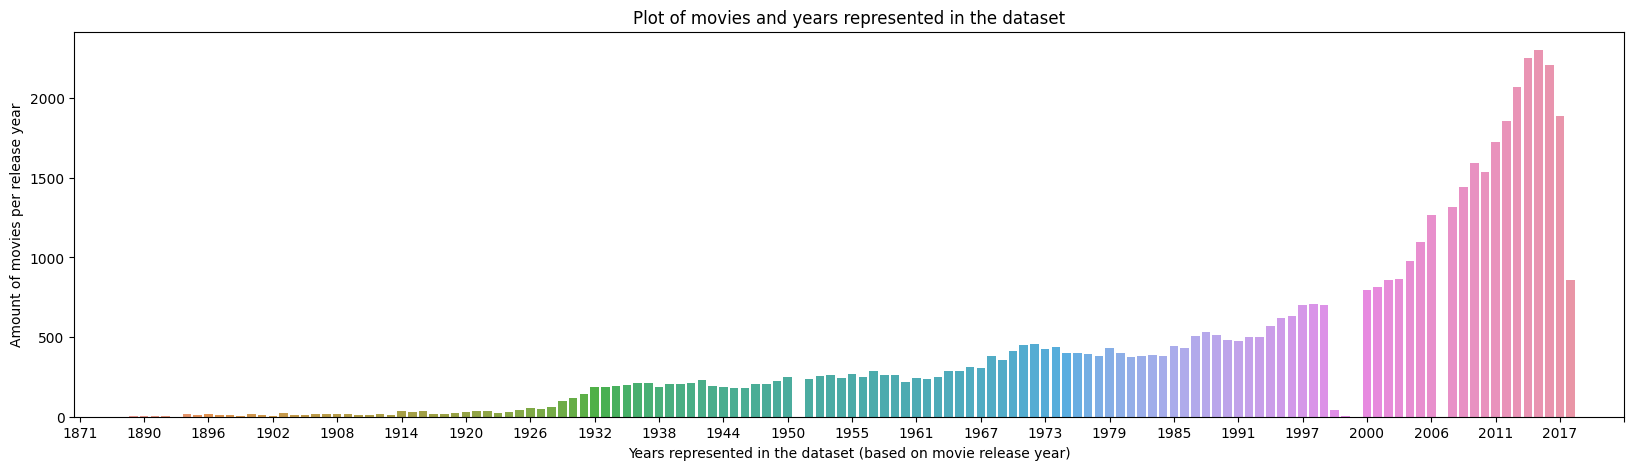

In [109]:
#setting figure size
plt.figure(figsize= (20,5))
sns.barplot(data = title_sum, y= 'title', x = 'year').set(title = 'Plot of movies and years represented in the dataset') #loading x,y axis and setting title
plt.xlabel("Years represented in the dataset (based on movie release year)") # X label title
plt.ylabel("Amount of movies per release year") #y label title
plt.xticks(np.arange(0, 150, 6)) #changing tick freqency on the x axis
plt.show()


### 1.1 e) Sum of ratings against movieId
Starting by seeing if it needs to be cleaned

In [110]:
#No missing values
df_ratings.isna().any()


userId     False
movieId    False
rating     False
dtype: bool

In [111]:
print(df_ratings['userId'].min())
print(df_ratings['userId'].max(), "\n")
print(df_ratings['userId'].info(), "\n")
print(df_ratings['userId'].describe())

#column looks good

1
283228 

<class 'pandas.core.series.Series'>
RangeIndex: 27753444 entries, 0 to 27753443
Series name: userId
Non-Null Count     Dtype
--------------     -----
27753444 non-null  int32
dtypes: int32(1)
memory usage: 105.9 MB
None 

count    2.775344e+07
mean     1.419420e+05
std      8.170740e+04
min      1.000000e+00
25%      7.117600e+04
50%      1.420220e+05
75%      2.124590e+05
max      2.832280e+05
Name: userId, dtype: float64


In [112]:
print(df_ratings['movieId'].min())
print(df_ratings['movieId'].max(), "\n")
print(df_ratings['movieId'].info(), "\n")
print(df_ratings['movieId'].describe())

#column looks good

1
193886 

<class 'pandas.core.series.Series'>
RangeIndex: 27753444 entries, 0 to 27753443
Series name: movieId
Non-Null Count     Dtype
--------------     -----
27753444 non-null  int32
dtypes: int32(1)
memory usage: 105.9 MB
None 

count    2.775344e+07
mean     1.848800e+04
std      3.510263e+04
min      1.000000e+00
25%      1.097000e+03
50%      2.716000e+03
75%      7.150000e+03
max      1.938860e+05
Name: movieId, dtype: float64


In [113]:
print(df_ratings['rating'].min())
print(df_ratings['rating'].max(), "\n")
print(df_ratings['rating'].info(), "\n")
print(df_ratings['rating'].describe())

#column looks good

0.5
5.0 

<class 'pandas.core.series.Series'>
RangeIndex: 27753444 entries, 0 to 27753443
Series name: rating
Non-Null Count     Dtype  
--------------     -----  
27753444 non-null  float32
dtypes: float32(1)
memory usage: 105.9 MB
None 

count    2.775344e+07
mean     3.530446e+00
std      1.066353e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


#### Preparing the data for plotting

In [114]:
rating_count = df_ratings.groupby(by = 'movieId', as_index = False)['rating'].count() #grouping data by movieId and counting amounts of ratings
rating_count

,movieId,rating
0,1,68469
1,2,27143
2,3,15585
3,4,2989
4,5,15474
...,...,...
53884,193876,1
53885,193878,1
53886,193880,1
53887,193882,1


In [115]:
most_rated_movies = rating_count.sort_values(['rating'], ascending=False) #sorts values on ratings high --> low
most_rated_movies = most_rated_movies.reset_index() #resetting index
most_rated_movies = most_rated_movies.rename(columns= {'index': 'original index'}) #keeping old index information but reassigning actual row index to match order df

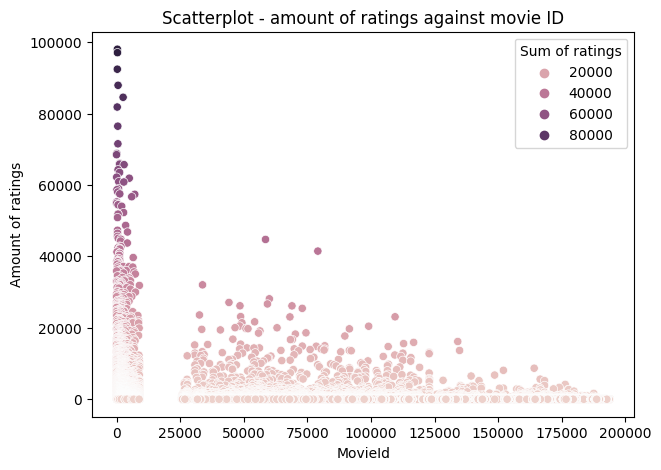

In [116]:
plt.figure(figsize= (7,5))
sns.scatterplot(data = most_rated_movies, y= 'rating', x = 'movieId', hue = 'rating').set(title = 'Scatterplot - amount of ratings against movie ID') #loading x,y axis and setting title
plt.xlabel("MovieId") # X label title
plt.ylabel("Amount of ratings") #y label title
plt.legend(title = 'Sum of ratings')

plt.show()

### 1.1 f) Plot and calculate mean ratings for the top ten most rated movies 

In [117]:
top_ten_ratings.head()

,userId,movieId,rating
42,4,1,4.0
73,4,110,4.5
102,4,260,4.5
107,4,296,5.0
111,4,318,5.0


In [118]:
# mean calculated for each of the top ten movies
top_ten_mean = top_ten_ratings.groupby(by = 'movieId', as_index = False)['rating'].mean() 
top_ten_mean

,movieId,rating
0,1,3.886649
1,110,4.008481
2,260,4.120455
3,296,4.173971
4,318,4.424188
5,356,4.056585
6,480,3.665034
7,527,4.257502
8,593,4.151412
9,2571,4.149695


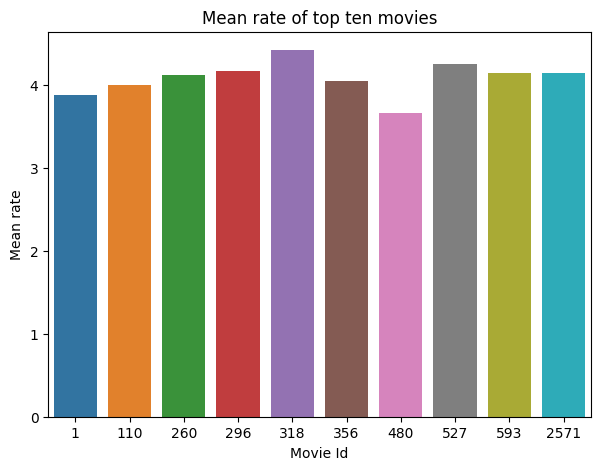

In [119]:
plt.figure(figsize= (7,5))
sns.barplot(data = top_ten_mean, y= 'rating', x = 'movieId').set(title = 'Mean rate of top ten movies') #loading x,y axis and setting title
plt.xlabel("Movie Id") # X label title
plt.ylabel("Mean rate") #y label title

plt.show()

## 1.2 Sparse matrix

Create pivot table containing index "movieId", columnes "userId" and values "ratings". Motivate any filtering and changes you make to the dataset

In [120]:
df_ratings.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [127]:
# adding column movie id to df_movies_years
df_movie_id = df_movies['movieId']
year_and_movie_id = df_movies_years.join(df_movie_id)

#cleaning new DF
year_and_movie_id['year'] = year_and_movie_id['year'].str.replace(r'\D+', '')
#removing movies prior to '95
year_and_movie_id = year_and_movie_id[year_and_movie_id['year'] > '1994']
year_and_movie_id= year_and_movie_id[year_and_movie_id['year'] < '2024']

#creating list with movie id's between 1995 - 2024
id_filtered = []
for i in year_and_movie_id['movieId']:
    id_filtered.append(i)   

/var/folders/_j/wrygfb3x2znc30ht6mt37s0h0000gn/T/ipykernel_33332/4272056.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  year_and_movie_id['year'] = year_and_movie_id['year'].str.replace(r'\D+', '')


In [130]:
filtered_ratings = df_ratings[df_ratings["movieId"].isin(id_filtered)]
filtered_ratings

,userId,movieId,rating
4,1,1449,4.5
5,1,1590,2.5
6,1,1591,1.5
9,1,2840,3.0
14,1,3826,2.0
...,...,...,...
27753429,283228,6377,5.0
27753430,283228,6874,4.0
27753441,283228,34405,4.5
27753442,283228,44761,4.5


##### As the set is large and my computer struggles to create the pivot table using the entire set I will not include movies prior to 1995

In [131]:
#created pivot table
pivot_ratings = filtered_ratings.pivot(index= 'movieId', columns= 'userId', values='rating').fillna(0)
pivot_ratings

/var/folders/_j/wrygfb3x2znc30ht6mt37s0h0000gn/T/ipykernel_33332/1557041941.py:1: PerformanceWarning: The following operation may generate 8331700960 cells in the resulting pandas object.
  pivot_ratings = filtered_ratings.pivot(index= 'movieId', columns= 'userId', values='rating').fillna(0)


userId,1,2,3,4,5,6,7,8,9,10,...,283219,283220,283221,283222,283223,283224,283225,283226,283227,283228
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
2,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
# created sparse matrix containing the values from the pivot table
sparse_mat = csr_matrix(pivot_ratings.values)

### The recommender system

In [155]:
#our model created with the use of KNN classifier. Using cosine similraity it will match our search with the top 5 matches using brute force algorithm
model_knn = NearestNeighbors(metric = 'cosine', algorithm= 'brute', n_neighbors= 5)

In [156]:
#training the model with our dataset
model_knn.fit(sparse_mat)

NearestNeighbors(algorithm='brute', metric='cosine')

In [176]:
# Defining function for our recommender system
# It will look at the rating of our chososen movie and recommend five movies most similar to the rating of our given movie.
def movie_rec(title, data, model, nr_rec):
    model.fit(data)
    index = process.extractOne(title, df_movies['title'])[2] #saves the index nr of our choosen movie
    print("Your selected movie is: ", df_movies['title'][index], "index number: ", index) #prints request and index information
    print('Searching for recommendations....')
    
    #here we initiate our rec system, tells it which data to use and how many recommendations we want.
    knn, idx = model.kneighbors(data[index], n_neighbors = nr_rec)
  
    #searches for recommendation and presents it according to similarity
    for i in idx:
        print(df_movies['title'][i].where(i != index))

movie_rec('heat', sparse_mat, model_knn, 6)


Your selected movie is:  Heat (1995) index number:  5
Searching for recommendations....
5                                                  NaN
331                                  Underneath (1995)
284                          Nina Takes a Lover (1994)
15                                       Casino (1995)
82     Once Upon a Time... When We Were Colored (1995)
257          Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object
